# TFG: Detecció i classificació d'atac en una xarxa informàtica mitjançant machine learning

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif,chi2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (precision_score, recall_score,f1_score,
accuracy_score,mean_squared_error,mean_absolute_error, roc_curve,
classification_report,auc)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


Using TensorFlow backend.
//anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
from sklearn.metrics import confusion_matrix

# Entrenar el model amb split kfold
def model_train(model,X,y,n_splits=4):
    skf=StratifiedKFold(n_splits=n_splits)
    scores = []
    for train_index,test_index in skf.split(X,y):
        X_train,X_test=X.iloc[train_index],X.iloc[test_index]
        y_train,y_test=y.iloc[train_index],y.iloc[test_index]
        model.fit(X_train,y_train)
        score=model.score(X_test,y_test)
        print('Puntuacio: {:.6f}'.format(score))
        scores.append(score)
    print('Puntuació mitjana: {:.6f}'.format(np.mean(scores)))
    cm_show(model,X_test,y_test)

def model_train_test(model,train_df,test_df,label):
    X_train= train_df[selected_features]
    y_train= train_df[label]
    X_test = test_df[selected_features]
    y_test = test_df[label]
    
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    
    print('Accuracy: {:.6f}'.format(accuracy_score(pred,y_test)))
    print('Recall: {:.6f}'.format(recall_score(pred,y_test,average = 'macro')))
    print('Precision: {:.6f}'.format(precision_score(pred,y_test,average = 'macro')))
    print('F1score: {:.6f}'.format(f1_score(pred,y_test,average = 'macro')))
    
    cm = cm_show(model,pred,y_test)
    
    return cm,model

#Funció per mostrar grafica de confusion matrix
def cm_show(model,pred,y_test):
    labels = y_test.unique().tolist()
    cm = confusion_matrix(y_test, pred, labels)
    ax= plt.subplot()
    sns.heatmap(cm,fmt='g', annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    
    return cm

# Funcion per mantenir la mateixa proporcio de mostres de cada classe
def same_percentage_each_class(X,y):
    labels = y.unique()
    max_samples = min([i for i in y.value_counts()])
    indices = np.array([])
    
    for label in labels:
        index = y[y == label].index.values
        np.random.shuffle(index)
        index =  index[0:max_samples]
        indices = np.concatenate((indices,index), axis=0)    
    np.random.shuffle(indices)
    return X.iloc[indices],y.iloc[indices]

#Atributs que no cal escalar: discrete, rates (ja estan en rang 0-1)
non_scale_features=['protocol_type_1','protocol_type_2','protocol_type_3','service_0','service_1','service_2'
                   ,'service_3','service_4','service_5','service_6','service_7','flag_0','flag_1','flag_2','flag_3',
                   'flag_4','land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login',
                   'serror_rate','srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
                   'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_same_srv_rate',
                   'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                   'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                   'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                   'dst_host_srv_rerror_rate']

#Atributs que necessiten reescalar: counts,nums,bytes,..
to_scale_features=['duration','src_bytes','dst_bytes','wrong_fragment','urgent','hot','num_root','num_file_creations'
                   ,'num_failed_logins','num_compromised','num_root','num_file_creations'
                   ,'num_shells','num_access_files','num_outbound_cmds','count','srv_count','dst_host_count'
                   ,'dst_host_srv_count']

discrete_features=['protocol_type_1','protocol_type_2','protocol_type_3','service_0','service_1','service_2'
                   ,'service_3','service_4','service_5','service_6','service_7','flag_0','flag_1','flag_2','flag_3',
                   'flag_4','land','logged_in','is_host_login','is_guest_login','root_shell',
                  'su_attempted','num_failed_logins','wrong_fragment',
                'num_compromised','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds']

attacks_cat=['DOS','R2L','U2R','probe']
attacks={'DOS':['apache2.','back.','land.','neptune.','mailbomb.','pod.','processtable.',
                'smurf.','teardrop.','udpstorm.','worm.'], 
         'R2L':['ftp_write.','guess_passwd.','httptunnel.','imap.','multihop.','named.',
                'phf.','sendmail.','snmpgetattack.','spy.','snmpguess.','warezclient.',
                'warezmaster.','xlock.','xsnoop.'],
         'U2R':['buffer_overflow.','loadmodule.','perl.','ps.','rootkit.','sqlattack.','xterm.'],
         'probe':['ipsweep.','mscan.','nmap.','portsweep.','satan.','saint.']}


def label_categoria(val):
    val2=0
    if val == 'normal.':
        val2='normal.'
        return val2
    val2='unknown.'
    for i in attacks_cat:
        if val in attacks[i]:
            val2=i
            break
    return val2

def label_categoria2(val):
    val2=0
    if val == 'normal':
        val2='normal'
        return val2
    val2='unknown'
    for i in attacks_cat:
        if val in attacks2[i]:
            val2=i
            break
    return val2

def label_atac(val):
    if val == 'normal.':
        return val
    else:
        return 'atac'


In [4]:
import pandas as pd

train_df=pd.read_csv("kdd-cup-1999-data/kddcup.data")
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
%%time
train_df=pd.read_csv("kdd-cup-1999-data/kddcup.data")
train_10_df = pd.read_csv("kdd-cup-1999-data/kddcup.data_10_percent")
corrected_df = pd.read_csv("kdd-cup-1999-data/corrected")

train_df.head()

CPU times: user 18.2 s, sys: 3.82 s, total: 22 s
Wall time: 19.3 s


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [32]:
len(corrected_df)

311029

In [6]:
%%time
train_df['label2'] = [label_categoria(i) for i in train_df['label']]
train_10_df['label2'] = [label_categoria(i) for i in train_10_df['label']]
corrected_df['label2'] = [label_categoria(i) for i in corrected_df['label']]

CPU times: user 2.64 s, sys: 70.3 ms, total: 2.71 s
Wall time: 2.46 s


In [7]:
train_df['label3'] = [label_atac(i) for i in train_df['label2']]
train_10_df['label3'] = [label_atac(i) for i in train_10_df['label2']]
corrected_df['label3'] = [label_atac(i) for i in corrected_df['label2']]

In [69]:
train_df['num_actions'] = train_df['num_root'] + train_df['num_file_creations'] + train_df['num_shells'] + train_df['num_access_files']
train_10_df['num_actions'] = train_10_df['num_root'] + train_10_df['num_file_creations'] + train_10_df['num_shells'] + train_10_df['num_access_files']
corrected_df['num_actions'] = corrected_df['num_root'] + corrected_df['num_file_creations'] + corrected_df['num_shells'] + corrected_df['num_access_files']


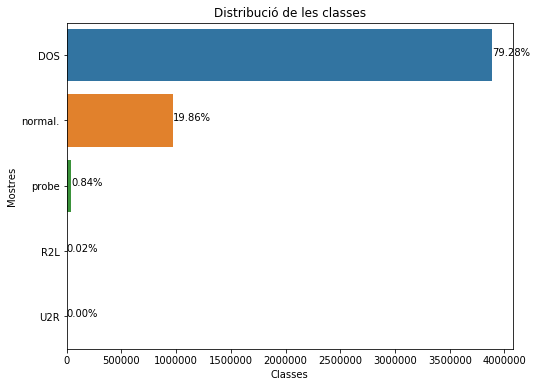

In [43]:
plt.figure(figsize=(8,6))

data = pd.DataFrame({'labels':train_df['label2'].value_counts().index,'values':train_df['label2'].value_counts().values})

ax = sns.barplot(x='values',y='labels',data = data)

plt.title('Distribució de les classes')
plt.xlabel('Classes')
plt.ylabel('Mostres')

total = len(train_df['label'])
for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

In [23]:
def transform_data(df,scale_features,service_encoder):
    #Categorical variable encoder
    service_encoded=service_encoder.transform(df['service'])

    protocol_encoder=ce.OneHotEncoder()
    protocol_encoded=protocol_encoder.fit_transform(df['protocol_type'])

    flag_encoder=ce.BinaryEncoder()
    flag_encoded=flag_encoder.fit_transform(df['flag'])

    #Treure les columnes originals, posar les noves
    df=pd.concat([protocol_encoded,service_encoded,flag_encoded,df],axis=1)
    df=df.drop(columns=['protocol_type', 'service', 'flag'])
    
    #Feature scaler
    #scaler=StandardScaler()
    scaler=MinMaxScaler() 

    #Escalar solo los atributos necesarios
    scaled_data=scaler.fit_transform(df[scale_features])
    scale_df = pd.DataFrame(scaled_data, index=df[scale_features].index, columns=df[scale_features].columns)

    #Asignar a la dataFrame original les columnes reescalades
    df[scale_features]=scale_df
    
    return df

In [24]:
%%time
service_encoder=ce.BinaryEncoder()
service_encoder = service_encoder.fit(train_df['service'])

corrected_df = transform_data(corrected_df,to_scale_features,service_encoder)
train_df = transform_data(train_df,to_scale_features,service_encoder)
train_10_df = transform_data(train_10_df,to_scale_features,service_encoder)

CPU times: user 51.1 s, sys: 32.7 s, total: 1min 23s
Wall time: 33 s


In [ ]:
%%time
from sklearn.feature_selection import SelectKBest,f_classif,chi2

#Tots els atributs menys la columna 'label'
v=list(train_df.columns.tolist())
v.remove('label')
v.remove('label2')
v.remove('label3')

model_classif=SelectKBest(f_classif,k=40)
selected_df=model_classif.fit_transform(train_df[v],train_df['label'])

In [33]:
classif_list = list(zip(v,model_classif.scores_))
classif_features = [i[0] for i in classif_list]
classif_score = [i[1] for i in classif_list]

classif_df = pd.DataFrame({'score': classif_score, 'features': classif_features}).sort_values(by=['score'],ascending = False)

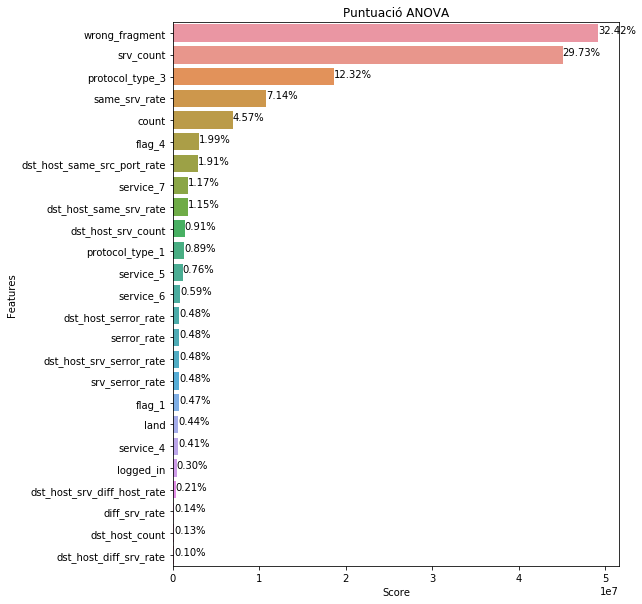

In [56]:
plt.figure(figsize=(8,10))

ax = sns.barplot(data = classif_df.head(25),x='score',y='features')

plt.title('Puntuació ANOVA')
plt.xlabel('Score')
plt.ylabel('Features')

total = classif_df['score'].sum()
for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

In [68]:
%%time
#Score function : chi2
model_chi2=SelectKBest(chi2,k=30)
selected_df=model_chi2.fit_transform(train_df[discrete_features],train_df['label'])

CPU times: user 26.4 s, sys: 4.21 s, total: 30.7 s
Wall time: 27.3 s


In [64]:
chi2_list = list(zip(discrete_features,model_chi2.scores_))
chi2_score = [i[1] for i in chi2_list]
chi2_features = [i[0] for i in chi2_list]
chi2_df = pd.DataFrame({'score': chi2_score, 'features': chi2_features}).sort_values(by=['score'],ascending = False)


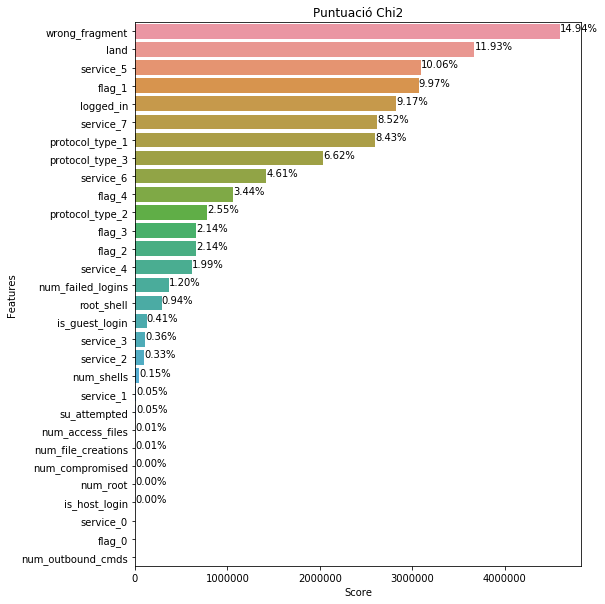

In [66]:
plt.figure(figsize=(8,10))

ax = sns.barplot(data = chi2_df,x='score',y='features')

plt.title('Puntuació Chi2')
plt.xlabel('Score')
plt.ylabel('Features')

total = chi2_df['score'].sum()
for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

In [8]:
#Quedarse amb els atributs finals
features=train_df.columns.tolist()
drop_features=['label','label2','label3','num_outbounds_cmds','is_host_login','service_0','flag_0'
              ,'su_attempted','urgent','num_shells',
              'root_shell']
selected_features=[i for i in features if i not in drop_features]


Accuracy: 0.919271
Recall: 0.599248
Precision: 0.553886
F1score: 0.533418
CPU times: user 7min 51s, sys: 5.11 s, total: 7min 56s
Wall time: 7min 57s


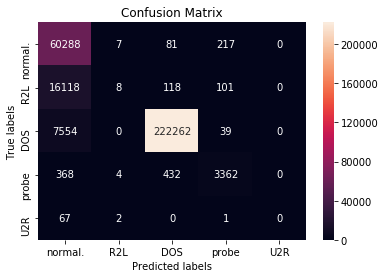

In [89]:
%%time
model = DecisionTreeClassifier()
lgbm =LGBMClassifier(learning_rate=0.01,n_estimators=100,class_weight='balanced')
svc=SVC(kernel='rbf',gamma='auto')
linear_svc=LinearSVC()

cm, clf = model_train_test(svc,train_10_df,corrected_df,'label2')


Accuracy: 0.734372
Recall: 0.614758
Precision: 0.524686
F1score: 0.384373
CPU times: user 40.9 s, sys: 3.43 s, total: 44.3 s
Wall time: 44.7 s


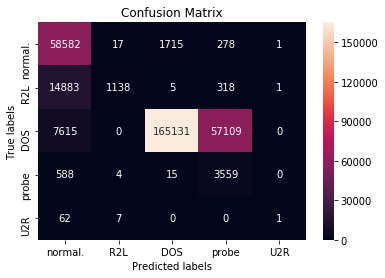

In [68]:
%%time
model = DecisionTreeClassifier()
cm,clf = model_train_test(model,train_df,corrected_df,'label2')

Accuracy: 0.906919
Recall: 0.694515
Precision: 0.413559
F1score: 0.403739
CPU times: user 6min 58s, sys: 21.5 s, total: 7min 19s
Wall time: 1min 17s


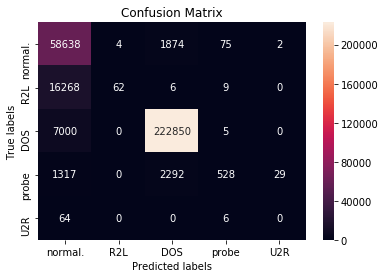

In [11]:
%%time
lgbm = LGBMClassifier(learning_rate=1,n_estimators=100)
cm2,c = model_train_test(lgbm,train_df,corrected_df,'label2')

In [15]:
%%
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

X = train_df[selected_features]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['label2'])

inpNeurones = 128 #[64,128,108,256]
hiddenNeurones = 64 #[32,64,128,108]
act = 'relu' #[relu,sigmoid,tanh]

model = Sequential()
model.add(Dense(inpNeurones,input_dim = 47, activation = act))
model.add(Dropout(dropout_ratio))
model.add(Dense(hiddenNeurones,activation = act))
model.add(Dropout(dropout_ratio))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

one_hot_labels = keras.utils.to_categorical(y, num_classes=np.unique(y).size)


#df_train, df_test = train_test_split(scaled_df, test_size=0.25)

X_train = train_df[selected_features]
y_train = label_encoder.fit_transform(train_df['label2'])
train_labels = keras.utils.to_categorical(y_train, num_classes=np.unique(y).size)

X_test = corrected_df[selected_features]
y_test = label_encoder.fit_transform(corrected_df['label2'])
test_labels = keras.utils.to_categorical(y_test, num_classes=np.unique(y).size)


model.fit(X_train, train_labels, epochs=5, batch_size=64)

results = model.evaluate(X_test, test_labels, batch_size=64)

Train on 4898431 samples
Epoch 1/5
4898431/4898431 [==============================] - 583s 119us/sample - loss: 0.0173 - accuracy: 0.9985
Epoch 2/5
4898431/4898431 [==============================] - 578s 118us/sample - loss: 0.0154 - accuracy: 0.9989
Epoch 3/5
4898431/4898431 [==============================] - 565s 115us/sample - loss: 0.0149 - accuracy: 0.9990
Epoch 4/5
4898431/4898431 [==============================] - 567s 116us/sample - loss: 0.0147 - accuracy: 0.9990
Epoch 5/5
311029/311029 [==============================] - 10s 31us/sample - loss: 1.3948 - accuracy: 0.9081


In [16]:
pred = model.predict(X_test)

In [19]:
test_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [26]:
max_pos = np.argmax(pred,axis=1)
test_pos = np.argmax(test_labels,axis=1)
confusion_matrix(max_pos, test_pos).T

array([3, 3, 3, ..., 3, 3, 3])

In [43]:
print('Accuracy: {:.6f}'.format(accuracy_score(max_pos,test_pos)))
print('Recall: {:.6f}'.format(recall_score(max_pos,test_pos,average = 'macro')))
print('Precision: {:.6f}'.format(precision_score(max_pos,test_pos,average = 'macro')))
print('F1score: {:.6f}'.format(f1_score(max_pos,test_pos,average = 'macro')))

Accuracy: 0.908099
Recall: 0.461890
Precision: 0.533811
F1score: 0.491928


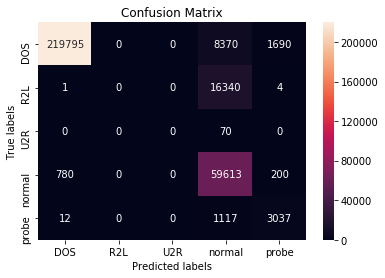

In [140]:
print('Accuracy: {:.6f}'.format(accuracy_score(max_pos,test_pos)))
print('Recall: {:.6f}'.format(recall_score(max_pos,test_pos,average = 'macro')))
print('Precision: {:.6f}'.format(precision_score(max_pos,test_pos,average = 'macro')))
print('F1score: {:.6f}'.format(f1_score(max_pos,test_pos,average = 'macro')))

labels = np.unique(y_test).tolist()
cm = confusion_matrix(max_pos, test_pos, labels).T
ax= plt.subplot()
sns.heatmap(cm,fmt='g', annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
labels_name = ['DOS','R2L','U2R','normal','probe']
ax.xaxis.set_ticklabels(labels_name); ax.yaxis.set_ticklabels(labels_name);
# 0 => DOS
# 1 => R2L
# 2 => U2R
# 3 => normal
# 4 => probe

In [ ]:
# Guardar un imatge del arbre de decisió
from sklearn.tree import export_graphviz

labels = train_df['label2'].unique().tolist()

export_graphviz(model,out_file='treecount.dot',feature_names=selected_features,class_names=labels,
                rounded=True,proportion = False, precision = 6,filled =True)

from subprocess import call
call(['dot','-Tpng','treecount.dot','-o','treecount.png'])

from IPython.display import Image
Image(filename = 'treecount.png')

### Proves dels paràmetres de cada model

In [10]:
#Parametres per provar en RandomizedSearchCV
params_dt = {'criterion': ['gini','entropy'], 
              'splitter': ['best','random'],
             'max_depth': [None,10,20,30,40,50],
             'max_features': [None,20,30,35,40,45],
             'max_leaf_nodes': [None],
             'min_samples_split': [2,3,4],
            }
params_lgbm = {'boosting_type': ['gbdt','dart','goss','rf'], 
              'num_leaves': [31,40,35,25,27],
              'max_depth': [-1,40,50,60,30],
              'learning_rate': [0.1,0.05,0.01,0.5,0.025],
               'n_estimators': [40,60,80,100,140,200],
               'min_split_gain': [0.,0.05,1e-3,1e-5]
              }
params_svc = {'C': [1,1.5,2,0.5,0.1], 
              'penalty': ['l1','l2'],
             'tol': [1e-4,1e-5,1e-3],
              'multi_class': ['ovr','crammer_singer'],
             }
params_mlp = {'act': ['relu','sigmoid','tanh'], 
              'loss': ['categorical_crossentropy'],
             'optimizer':['rmsprop','sgd','adagrad'],
              'batch_size': [64,128,32,256],
              'epochs':[3],
              'inpNeurones':[64,128,108,256],
              'hiddenNeurones':[32,64,128,108],
              'dropout_ratio':[0.2,0.3,0.4,0.5,0.8]
             }



In [ ]:
%%time
model = DecisionTreeClassifier()
lgbm =LGBMClassifier()
svc=SVC(kernel='rbf',gamma='auto')
linear_svc=LinearSVC()

clf = RandomizedSearchCV(lgbm, params_lgbm, random_state=1, n_iter=3, cv=4,scoring='accuracy')
clf = model_train_test(clf,train_df,corrected_df,'label2')


In [ ]:
X = train_df[selected_features]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['label2'])

one_hot_labels = keras.utils.to_categorical(y, num_classes=np.unique(y).size)

X_train = train_df[selected_features]
y_train = label_encoder.fit_transform(train_df['label2'])
train_labels = keras.utils.to_categorical(y_train, num_classes=np.unique(y).size)

X_test = corrected_df[selected_features]
y_test = label_encoder.fit_transform(corrected_df['label2'])
test_labels = keras.utils.to_categorical(y_test, num_classes=np.unique(y).size)

clf.fit(X_train, train_labels)

score = clf.score(X_test, test_labels)
print('Puntuacio: {:.6f}'.format(score))
    
cm_show(clf,X_test,y_test)


In [15]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

X = train_df[selected_features]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_10_df['label2'])

inpNeurones = 128 #[64,128,108,256]
hiddenNeurones = 64 #[32,64,128,108]
hiddenNeurones2 = 32
dropout_ratio = 0.5 #[0.2,0.3,0.4,0.5,0.8]
act = 'sigmoid' #[relu,sigmoid,tanh]
   
model = Sequential()
model.add(Dense(inpNeurones,input_dim = 47, activation = act))
model.add(Dropout(dropout_ratio))
model.add(Dense(hiddenNeurones,activation = act))
model.add(Dropout(dropout_ratio))
#model.add(Dense(hiddenNeurones2,activation = act))
#model.add(Dropout(dropout_ratio))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

one_hot_labels = keras.utils.to_categorical(y, num_classes=np.unique(y).size)


#df_train, df_test = train_test_split(scaled_df, test_size=0.25)

X_train = train_10_df[selected_features]
y_train = label_encoder.fit_transform(train_10_df['label2'])
train_labels = keras.utils.to_categorical(y_train, num_classes=np.unique(y).size)

X_test = corrected_df[selected_features]
y_test = label_encoder.fit_transform(corrected_df['label2'])
test_labels = keras.utils.to_categorical(y_test, num_classes=np.unique(y).size)


model.fit(X_train, train_labels, epochs=3, batch_size=64)

results = model.evaluate(X_test, test_labels, batch_size=64)

Train on 494021 samples
Epoch 1/3
494021/494021 [==============================] - 63s 127us/sample - loss: 0.0720 - accuracy: 0.9808
Epoch 2/3
494021/494021 [==============================] - 64s 129us/sample - loss: 0.0372 - accuracy: 0.9909
Epoch 3/3
311029/311029 [==============================] - 12s 39us/sample - loss: 1.0191 - accuracy: 0.9140


### Codi de versions anteriors
A continuació, hi ha el codi de versions anteriors <br>
El test i entrenament fets amb només el conjunt d'entrenament <br>
Cada model només amb els resultats d'accuracy <br>

In [3]:
from sklearn.metrics import confusion_matrix

# Entrenar el model amb split kfold
def model_train(model,X,y,n_splits=4):
    skf=StratifiedKFold(n_splits=n_splits)
    scores = []
    for train_index,test_index in skf.split(X,y):
        X_train,X_test=X.iloc[train_index],X.iloc[test_index]
        y_train,y_test=y.iloc[train_index],y.iloc[test_index]
        model.fit(X_train,y_train)
        score=model.score(X_test,y_test)
        print('Puntuacio: {:.6f}'.format(score))
        scores.append(score)
    print('Puntuació mitjana: {:.6f}'.format(np.mean(scores)))
    cm_show(model,X_test,y_test)

def model_train_test(model,train_df,test_df,label):
    X_train= train_df[selected_features]
    y_train= train_df[label]
    X_test = test_df[selected_features]
    y_test = test_df[label]
    
    model.fit(X_train,y_train)
    
    score = model.score(X_test,y_test)
    print('Puntuacio: {:.6f}'.format(score))
    
    cm_show(model,X_test,y_test)
    
    return model

#Funció per mostrar grafica de confusion matrix
def cm_show(model,X_test,y_test):
    labels = y_test.unique().tolist()
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred, labels)
    ax= plt.subplot()
    sns.heatmap(cm,fmt='g', annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

# Funcion per mantenir la mateixa proporcio de mostres de cada classe
def same_percentage_each_class(X,y):
    labels = y.unique()
    max_samples = min([i for i in y.value_counts()])
    indices = np.array([])
    
    for label in labels:
        index = y[y == label].index.values
        np.random.shuffle(index)
        index =  index[0:max_samples]
        indices = np.concatenate((indices,index), axis=0)    
    np.random.shuffle(indices)
    return X.iloc[indices],y.iloc[indices]



Puntuacio: 0.996071
Puntuacio: 0.996333
Puntuacio: 0.997166
Puntuació mitjana: 0.996523
[[    9     2     0     6     0]
 [    2   310     1    18     0]
 [    0     0 15299     8     2]
 [    4    20     4 22401    18]
 [    1     0     2    31  3851]]
CPU times: user 2.34 s, sys: 236 ms, total: 2.58 s
Wall time: 2.64 s


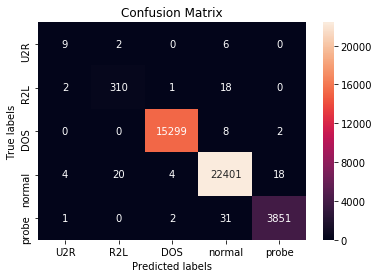

In [618]:
%%time
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

X=train_df[selected_features]
y=train_df['label2']

#X,y = same_percentage_each_class(X,y) #Mantenir amb el mateix percentatge en 50% atac/normal

model = DecisionTreeClassifier()

model_train(model,X,y,3)


Puntuacio: 0.998982
Puntuacio: 0.990047
Puntuació mitjana: 0.994514
CPU times: user 4min 47s, sys: 27 s, total: 5min 14s
Wall time: 3min 30s


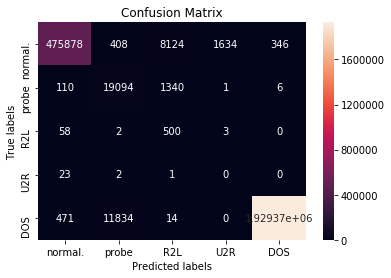

In [653]:
%%time
#Gradient Boosting
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score


X=train_df[selected_features]
y=train_df['label2']

#X,y = same_percentage_each_class(X,y)

lgbm=LGBMClassifier(learning_rate=0.1,n_estimators=20)

model_train(lgbm,X,y,2)


SVC:
Puntuacio: 0.993547
Puntuacio: 0.905751
Puntuació mitjana: 0.949649
[[    25      0      0      0      0      0      0      0      0      1
       0      0      0      0      0      0      0      0      0      0
       0      0      0]
 [     0      0      0      0      0      0      0      0      0      1
       0      0      0      0      3      0      0      0      0      0
       0      0      0]
 [     0      0     56      0      0      0      0      0      0   1045
       0      0      0      0      0      0      0      0      0      0
       0      0      0]
 [     0      0      0    541      0      0      0      0      0     82
       0      0      0      0      0      0      0      0      0      0
       0      0      0]
 [     0      0      0      0      0      0      0      0      0      1
       0      0      0      0      2      0      0      0      0      0
       0      0      0]
 [     0      0      0     99      0      0      0      0      0     16
       0      0

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


CPU times: user 5min 11s, sys: 3.78 s, total: 5min 14s
Wall time: 5min 15s


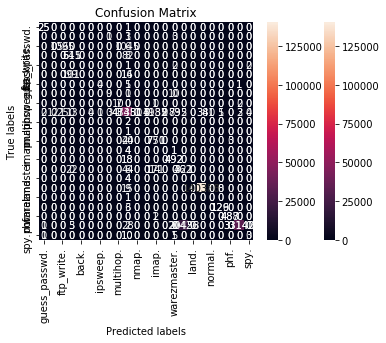

In [303]:
%%time
#Support Vector Machine
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


X=scaled_df[selected_features]
y=df2['label']

#X,y = same_percentage_each_class(X,y)

svc=SVC(kernel='rbf',gamma='auto')
linear_svc=LinearSVC()

#one vs rest multiclass
print("SVC:") 
model_train(svc,X,y,2)


#one vs one multiclass 
print("LinearSVC:")
model_train(linear_svc,X,y,2)


# Multiples Classificadors

Classificador atac/normal <br>
    if atac : Classificador dos/u2r/r2l/probe <br>
        if dos : Clf dos <br>
        elif u2r : clf u2r <br>
        elif r2l : clf r2l <br> 
        elif probe : clf probe <br>
        

In [53]:
from sklearn.base import clone

class ClassifierMultiple():
    def __init__(self,model):
        self.clf = clone(model) # normal/atac
        self.clf_atac = clone(model) #dos/u2r/r2l/probe
        self.clf_dict = { # diccionari amb els 4 tipus d'atac
            'DOS':clone(model),
            'R2L':clone(model),
            'U2R':clone(model),
            'probe':clone(model)
        }

    def fit(self,data):
        #Entrenar amb dades X a cada clasificador
        self.model_train(self.clf,data,'label3') # atac/normal
        
        data_train = data[data['label3'] == 'atac']
        self.model_train(self.clf_atac,data_train,'label2') # dos/u2r/r2l/probe
        
        '''
        data_train = data[data['label2'] == 'DOS']
        self.model_train(self.clf_dict['DOS'],data_train,'label') # dos atacs
        
        data_train = data[data['label2'] == 'R2L']
        self.model_train(self.clf_dict['R2L'],data_train,'label') # r2l atacs
        
        data_train = data[data['label2'] == 'U2R']
        self.model_train(self.clf_dict['U2R'],data_train,'label') # u2r atacs
        
        data_train = data[data['label2'] == 'probe']
        self.model_train(self.clf_dict['probe'],data_train,'label') # probe atacs
        '''
        
    def model_train(self,model,data,label_name):
        X = data[selected_features]
        y = data[label_name]
        model.fit(X,y)
    def score(self,predicted,y_test):
        index = y_test.index
        pred = pd.DataFrame(predicted, index=index)
        results = pd.concat([y_test,pred], axis=1, ignore_index=True)
        return accuracy_score(results[0],results[1])
    def predict(self,X_test):
        old_indices = X_test.index
        X = X_test.reset_index(drop=True) #restaurar els indices de 0 a n

        results = pd.Series([])
        X_indices = X.index
        preds_3 = self.clf.predict(X.iloc[:]) # predir si son normal/atac
        preds_3 = pd.Series(preds_3, index=X_indices,name='preds_3') # Canviar els indexs dels valors predicts
        
        # guardar com a resultat final els que tenen etiqueta 'normal'
        results = pd.concat([results,preds_3[preds_3 == 'normal.']],axis=0) 
        
        X_test_3 = preds_3[preds_3 == 'atac'] # continuar classificar amb els atacs
        indices_3 = X_test_3.index # guardar els indices que son 'atac'
        
        preds_2 = self.clf_atac.predict(X.iloc[indices_3]) # dóna prediccions de dos/r2l/u2r/probe
        preds_2 = pd.Series(preds_2, index=indices_3,name='preds_2') # reestaurar els indices
        
        results = pd.concat([results,preds_2],axis=0)
        
        '''
        for atac_type in self.clf_dict.keys():
            preds_1 = preds_2[preds_2 == atac_type]
            indices_1 = preds_1.index
            preds = self.clf_dict[atac_type].predict(X.iloc[indices_1])
            preds = pd.Series(preds, index=indices_1,name='preds_1')
            results = pd.concat([results,preds],axis=0)
        '''
        
        results = results.sort_index() # ordenar per el index
        return results

Accuracy: 0.731221
Recall: 0.392811
Precision: 0.539080
F1score: 0.364531
CPU times: user 13.4 s, sys: 743 ms, total: 14.1 s
Wall time: 10.2 s


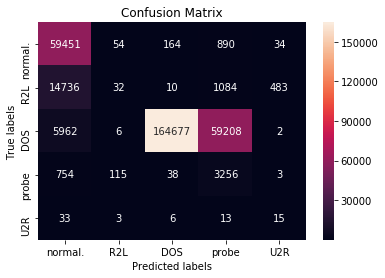

In [69]:
%%time
model = DecisionTreeClassifier()
clf_multiple = ClassifierMultiple(model)

label = 'label2'

X_train= train_10_df[selected_features]
y_train= train_10_df[label]
X_test = corrected_df[selected_features]
y_test = corrected_df[label]

clf_multiple.fit(train_10_df)
pred = clf_multiple.predict(X_test)

print('Accuracy: {:.6f}'.format(accuracy_score(pred,y_test)))
print('Recall: {:.6f}'.format(recall_score(pred,y_test,average = 'macro')))
print('Precision: {:.6f}'.format(precision_score(pred,y_test,average = 'macro')))
print('F1score: {:.6f}'.format(f1_score(pred,y_test,average = 'macro')))

cm_show(model,pred,y_test)

In [294]:
# Decision Tree
from sklearn.model_selection import train_test_split

model = DecisionTreeClassifier()
clf_multiple = ClassifierMultiple(model)
clf_multiple.train(X_train)
predict = clf_multiple.predict(X_test[selected_features])
accuracy_score(predict,X_test['label'])



0.9996923226401956

In [298]:
# Gradien Boosting
from sklearn.model_selection import train_test_split
X=df2[selected_features]
y=df2

X_train, X_test = train_test_split(df2, test_size=0.25)

model = LGBMClassifier(learning_rate=0.01,n_estimators=100)
clf_multiple = ClassifierMultiple(model)
clf_multiple.train(X_train)
predict = clf_multiple.predict(X_test[selected_features])
accuracy_score(predict,X_test['label'])

0.998477806746231

## Xarxes neuronals


In [19]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

X = train_df[selected_features]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['label2'])


model = Sequential()
model.add(Dense(64, input_dim=47, activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

one_hot_labels = keras.utils.to_categorical(y, num_classes=np.unique(y).size)


#df_train, df_test = train_test_split(scaled_df, test_size=0.25)

X_train = train_df[selected_features]
y_train = label_encoder.fit_transform(train_df['label2'])
train_labels = keras.utils.to_categorical(y_train, num_classes=np.unique(y).size)

X_test = corrected_df[selected_features]
y_test = label_encoder.fit_transform(corrected_df['label2'])
test_labels = keras.utils.to_categorical(y_test, num_classes=np.unique(y).size)


model.fit(X_train, train_labels, epochs=3, batch_size=64)

results = model.evaluate(X_test, test_labels, batch_size=64)

Train on 4898431 samples
Epoch 1/5
4898431/4898431 [==============================] - 314s 64us/sample - loss: 0.0077 - accuracy: 0.9991
Epoch 2/5
4898431/4898431 [==============================] - 312s 64us/sample - loss: 0.0061 - accuracy: 0.9995
Epoch 3/5
4898431/4898431 [==============================] - 312s 64us/sample - loss: 0.0059 - accuracy: 0.9996
Epoch 4/5
4898431/4898431 [==============================] - 311s 64us/sample - loss: 0.0058 - accuracy: 0.9996
Epoch 5/5
311029/311029 [==============================] - 8s 26us/sample - loss: 2.0060 - accuracy: 0.8675


In [431]:
#v=['duration','src_bytes','dst_bytes','land','wrong_fragment','urgent']
#v=['hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
#'num_file_creations','num_shells','num_access_files','num_actions','num_outbound_cmds','is_host_login','is_guest_login']
#v=['count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
#'same_srv_rate','diff_srv_rate','srv_diff_host_rate']
v=['dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']

#pivot table per analitzar dades per label
pd.pivot_table(data_df,index=['label'],values=v,aggfunc='count')


,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,dst_host_srv_diff_host_rate,dst_host_srv_rerror_rate,dst_host_srv_serror_rate
label,,,,,,,,,,
back.,2203,2203,2203,2203,2203,2203,2203,2203,2203,2203
buffer_overflow.,30,30,30,30,30,30,30,30,30,30
ftp_write.,8,8,8,8,8,8,8,8,8,8
guess_passwd.,53,53,53,53,53,53,53,53,53,53
imap.,12,12,12,12,12,12,12,12,12,12
ipsweep.,12481,12481,12481,12481,12481,12481,12481,12481,12481,12481
land.,21,21,21,21,21,21,21,21,21,21
loadmodule.,9,9,9,9,9,9,9,9,9,9
multihop.,7,7,7,7,7,7,7,7,7,7


In [4]:
#llistes d'atributs per tipus de contingut
basic_features=['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent']

content_features=['hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login']

traffic_features=['count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']

In [98]:
all_features=['duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbounds_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'label',
'success_pred']

discrete_features=['protocol_type_1','protocol_type_2','protocol_type_3','service_0','service_1','service_2'
                   ,'service_3','service_4','service_5','service_6','service_7','flag_0','flag_1','flag_2','flag_3',
                   'flag_4','land','logged_in','is_host_login','is_guest_login','root_shell',
                  'su_attempted',
                  'num_failed_logins','wrong_fragment',
                'num_compromised','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds']
continuous_features=['duration','src_bytes','dst_bytes','flag','wrong_fragment','urgent','hot','num_failed_logins',
                     'num_compromised','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds'
                     'count','srv_count','serror_rate','srv_serror_rate',
'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
'dst_host_srv_rerror_rate']